# DAA Experiment Harness (Template)
**Tujuan**: kerangka eksperimen untuk membandingkan *Algoritma A* vs *Algoritma B* pada instance unik per kelompok.
1. Isi `algo_A` dan `algo_B`.
2. Sesuaikan `generate_instances` atau loader data.
3. Atur `Ns`, `repeats`, `seed`.


In [60]:
import os, time, random, statistics
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

Path('results').mkdir(exist_ok=True)

random.seed(42)
np.random.seed(42)

## Data Aquisition

In [61]:
##LOAD DATA

import pandas as pd

df = pd.read_csv(
    r"E:\DAA_Kelompok4_KelasA\data\normalized_fix_2.csv"
)

df.head(10)

,Hari,Mata Kuliah,Semester,SKS,Dosen,Ruang,Kelas,Kapasitas Kelas,start,finish,duration,jumlah_mahasiswa,profit_density
0,Senin,Kalkulus I,1,3,SUPRIYADI WIBOWO,R001,A,25,09:20:00,10:10:00,50.0,16,0.06
1,Senin,Kalkulus I,1,3,SUPRIYADI WIBOWO,R001,A,25,10:15:00,11:05:00,50.0,13,0.06
2,Senin,Kalkulus I,1,3,SUPRIYADI WIBOWO,R001,A,25,11:10:00,12:00:00,50.0,22,0.06
3,Senin,Pengolahan Citra Digital,5,3,HERI PRASETYO,R001,B,25,13:00:00,13:50:00,50.0,24,0.06
4,Senin,Pengolahan Citra Digital,5,3,HERI PRASETYO,R001,B,25,13:55:00,14:45:00,50.0,20,0.06
5,Senin,Pengolahan Citra Digital,5,3,HERI PRASETYO,R001,B,25,15:30:00,16:20:00,50.0,17,0.06
6,Senin,Data Mining,5,3,WIRANTO,R001,E,25,16:25:00,17:15:00,50.0,22,0.06
7,Senin,Data Mining,5,3,WIRANTO,R001,E,25,18:10:00,19:00:00,50.0,14,0.06
8,Senin,Data Mining,5,3,WIRANTO,R001,E,25,22:15:00,23:05:00,50.0,16,0.06
9,Senin,Bahasa Indonesia,1,2,KUNDHARU SADDHONO,R002,C,40,13:00:00,13:50:00,50.0,34,0.04


In [62]:
df.columns

Index(['Hari', 'Mata Kuliah', 'Semester', 'SKS', 'Dosen', 'Ruang', 'Kelas',
       'Kapasitas Kelas', 'start', 'finish', 'duration', 'jumlah_mahasiswa',
       'profit_density'],
      dtype='object')

In [63]:
def load_dataset(path):
    df = pd.read_csv(path)

    # FORMAT JAM:MENIT:DETIK
    df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S').dt.time
    df['finish'] = pd.to_datetime(df['finish'], format='%H:%M:%S').dt.time

    return df

## Implementasi Algoritma A (Greedy EFT)

In [64]:
def run_algo_eft(data):
    start_time = time.perf_counter()

    sorted_data = data.sort_values(
    by=["finish_abs", "start_abs", "id"], kind="mergesort")
    schedule = []
    last_finish = -1

    for _, row in sorted_data.iterrows():
        if row["start_abs"] >= last_finish:
            schedule.append(row)
            last_finish = row["finish_abs"]

    runtime_ms = (time.perf_counter() - start_time) * 1000
    return schedule, runtime_ms

In [65]:
import pandas as pd
import time

# =========================================================
# DATA KASUS KECIL
# =========================================================

data_small = pd.DataFrame({
    "id": [0, 1, 2, 3, 4],
    "Hari": ["Senin"] * 5,
    "start": ["08:00:00", "08:30:00", "09:00:00", "10:30:00", "09:30:00"],
    "finish": ["09:00:00", "10:00:00", "10:30:00", "11:30:00", "11:00:00"]
})

# Mapping hari
day_map = {"Senin": 0}

def get_minutes(day, time_str):
    h, m, s = map(int, time_str.split(":"))
    return day_map[day] * 24 * 60 + h * 60 + m

data_small["start_abs"] = data_small.apply(
    lambda x: get_minutes(x["Hari"], x["start"]), axis=1
)
data_small["finish_abs"] = data_small.apply(
    lambda x: get_minutes(x["Hari"], x["finish"]), axis=1
)

# =========================================================
# JALANKAN EFT PADA KASUS KECIL
# =========================================================

schedule, runtime = run_algo_eft(data_small)

print("Runtime (ms):", runtime)
print("ID terpilih :", [row["id"] for row in schedule])

print("\nDetail interval terpilih:")
for row in schedule:
    print(
        f"ID {row['id']} | "
        f"{row['start']}–{row['finish']}"
    )


Runtime (ms): 3.877800001646392
ID terpilih : [0, 2, 3]

Detail interval terpilih:
ID 0 | 08:00:00–09:00:00
ID 2 | 09:00:00–10:30:00
ID 3 | 10:30:00–11:30:00


## Implementasi Algoritma B (Greedy Profit Density)

In [66]:
def run_algo_density(data):
    start_time = time.perf_counter()

    sorted_data = data.sort_values(
    by=["finish_abs", "start_abs", "id"],  # Disamakan dengan logika EFT
    ascending=[True, True, True],          # Disamakan (Ascending semua)
    kind="mergesort")
    schedule = []
    occupied = []

    for _, row in sorted_data.iterrows():
        s, f = row["start_abs"], row["finish_abs"]
        conflict = False

        for os, of in occupied:
            if s < of and f > os:
                conflict = True
                break

        if not conflict:
            schedule.append(row)
            occupied.append((s, f))

    runtime_ms = (time.perf_counter() - start_time) * 1000
    return schedule, runtime_ms

In [67]:
import pandas as pd
import time

# =========================================================
# DATA KASUS KECIL
# =========================================================

data_small = pd.DataFrame({
    "id": [0, 1, 2, 3, 4],
    "Hari": ["Senin"] * 5,
    "start": ["08:00:00", "08:30:00", "09:00:00", "10:30:00", "09:30:00"],
    "finish": ["09:00:00", "10:00:00", "10:30:00", "11:30:00", "11:00:00"]
})

day_map = {"Senin": 0}

def get_minutes(day, time_str):
    h, m, s = map(int, time_str.split(":"))
    return day_map[day] * 24 * 60 + h * 60 + m

data_small["start_abs"] = data_small.apply(
    lambda x: get_minutes(x["Hari"], x["start"]), axis=1
)
data_small["finish_abs"] = data_small.apply(
    lambda x: get_minutes(x["Hari"], x["finish"]), axis=1
)

# =========================================================
# JALANKAN GREEDY DENSITY PADA KASUS KECIL
# =========================================================

schedule_den, runtime_den = run_algo_density(data_small)

print("Runtime (ms):", runtime_den)
print("ID terpilih :", [row["id"] for row in schedule_den])

print("\nDetail interval terpilih:")
for row in schedule_den:
    print(
        f"ID {row['id']} | "
        f"{row['start']}–{row['finish']}"
    )


Runtime (ms): 4.465599995455705
ID terpilih : [0, 2, 3]

Detail interval terpilih:
ID 0 | 08:00:00–09:00:00
ID 2 | 09:00:00–10:30:00
ID 3 | 10:30:00–11:30:00


## Pembangkit/Loader Instance (SESUAIKAN)

In [68]:
import pandas as pd

# =========================================================
# 1. LOAD DATASET
# =========================================================

def load_dataset(path):
    df = pd.read_csv(path)

    # Pastikan kolom waktu string
    df['start'] = df['start'].astype(str)
    df['finish'] = df['finish'].astype(str)

    # Mapping hari ke angka
    day_map = {
        'Senin': 0,
        'Selasa': 1,
        'Rabu': 2,
        'Kamis': 3,
        'Jumat': 4,
        'Sabtu': 5,
        'Minggu': 6
    }

    def get_minutes(day, time_str):
        if day not in day_map:
            return -1
        h, m, s = map(int, time_str.split(':'))
        return day_map[day] * 24 * 60 + h * 60 + m

    # Konversi ke waktu absolut
    df['start_abs'] = df.apply(
        lambda x: get_minutes(x['Hari'], x['start']), axis=1
    )
    df['finish_abs'] = df.apply(
        lambda x: get_minutes(x['Hari'], x['finish']), axis=1
    )

    # Tambahkan ID unik
    df['id'] = df.index

    return df


In [69]:
# =========================================================
# 2. GENERATE INSTANCES
# =========================================================

def generate_instances(df, min_size=2):
    """
    1 instance = kelas-kelas pada hari & ruang yang sama
    """

    instances = []

    grouped = df.groupby(['Hari', 'Ruang'])

    for (hari, ruang), group in grouped:
        if len(group) >= min_size:
            instances.append({
                'hari': hari,
                'ruang': ruang,
                'data': group.sort_values(
                    by=['start_abs', 'finish_abs']
                ).reset_index(drop=True)
            })

    return instances


In [70]:
path = r"E:\DAA_Kelompok4_KelasA\data\normalized_fix_2.csv"

df = load_dataset(path)
instances = generate_instances(df)

print("Jumlah instance:", len(instances))

print("\nContoh instance pertama:")
print("Hari :", instances[0]['hari'])
print("Ruang:", instances[0]['ruang'])
print(instances[0]['data'].head())


Jumlah instance: 50

Contoh instance pertama:
Hari : Jumat
Ruang: R001
    Hari             Mata Kuliah  Semester  SKS           Dosen Ruang Kelas  \
0  Jumat  Pendidikan Agama Islam         1    2  RELLY PRIHATIN  R001     A   
1  Jumat  Pendidikan Agama Islam         1    2  RELLY PRIHATIN  R001     A   

   Kapasitas Kelas     start    finish  duration  jumlah_mahasiswa  \
0               25  16:25:00  17:15:00      50.0                15   
1               25  18:10:00  19:00:00      50.0                22   

   profit_density  start_abs  finish_abs   id  
0            0.04       6745        6795  334  
1            0.04       6850        6900  335  


## Evaluator & Timing

In [71]:
# =========================================================
# EVALUATOR SOLUSI
# =========================================================

def evaluate_schedule(schedule):
    """
    schedule: list of rows (hasil run_algo_*)
    """

    n_selected = len(schedule)

    # Total profit (SKS)
    total_sks = sum(row['SKS'] for row in schedule)

    # Validitas (tidak konflik)
    is_valid = True
    for i in range(len(schedule)):
        for j in range(i + 1, len(schedule)):
            a = schedule[i]
            b = schedule[j]
            if not (
                a['finish_abs'] <= b['start_abs'] or
                b['finish_abs'] <= a['start_abs']
            ):
                is_valid = False
                break

    return {
        'n_selected': n_selected,
        'total_sks': total_sks,
        'is_valid': is_valid
    }


In [72]:
import time

def run_with_timing_precise(algo_func, data):
    t0 = time.perf_counter()
    schedule, _ = algo_func(data)
    t1 = time.perf_counter()
    return schedule, (t1 - t0) * 1000


In [73]:
##GAP EVALUATOR - EFT BASELINE
def compute_gap(optimal_profit, algo_profit):
    if optimal_profit == 0:
        return 0.0
    return (optimal_profit - algo_profit) / optimal_profit


In [74]:
inst = instances[0]
data_inst = inst['data']


In [75]:
eft_schedule, eft_time = run_with_timing_precise(run_algo_eft, data_inst)
eft_eval = evaluate_schedule(eft_schedule)

print("EFT Evaluation:", eft_eval)
print("Runtime (ms):", eft_time)


EFT Evaluation: {'n_selected': 2, 'total_sks': 4, 'is_valid': True}
Runtime (ms): 3.684600000269711


In [76]:
den_schedule, den_time = run_with_timing_precise(run_algo_density, data_inst)
den_eval = evaluate_schedule(den_schedule)

print("Density Evaluation:", den_eval)
print("Runtime (ms):", den_time)


Density Evaluation: {'n_selected': 2, 'total_sks': 4, 'is_valid': True}
Runtime (ms): 2.9874999963794835


In [77]:
gap = compute_gap(eft_eval['total_sks'], den_eval['total_sks'])
print("Gap:", gap)


Gap: 0.0


## Eksekusi Eksperimen (atur parameter)

In [78]:
import pandas as pd
import numpy as np
import time

# =========================================================
# 1. LOAD & PREPROCESS DATA
# =========================================================

df = pd.read_csv(
    r"E:\DAA_Kelompok4_KelasA\data\normalized_fix_2.csv"
)
df["profit_density"] = df["profit_density"].fillna(0)

day_map = {
    'Senin': 0,
    'Selasa': 1,
    'Rabu': 2,
    'Kamis': 3,
    'Jumat': 4,
    'Sabtu': 5,
    'Minggu': 6
}

def get_minutes(day, time_str):
    if day not in day_map:
        return -1
    h, m, s = map(int, time_str.split(':'))
    return day_map[day] * 24 * 60 + h * 60 + m

df["start_abs"] = df.apply(lambda x: get_minutes(x["Hari"], x["start"]), axis=1)
df["finish_abs"] = df.apply(lambda x: get_minutes(x["Hari"], x["finish"]), axis=1)

# Add 'id' column based on the DataFrame's index
df['id'] = df.index

# =========================================================
# 2. GREEDY ALGORITHMS
# =========================================================

def run_algo_eft(data):
    start_time = time.perf_counter()

    sorted_data = data.sort_values(
    by=["finish_abs", "start_abs", "id"], kind="mergesort")
    schedule = []
    last_finish = -1

    for _, row in sorted_data.iterrows():
        if row["start_abs"] >= last_finish:
            schedule.append(row)
            last_finish = row["finish_abs"]

    runtime_ms = (time.perf_counter() - start_time) * 1000
    return schedule, runtime_ms


def run_algo_density(data):
    start_time = time.perf_counter()

    sorted_data = data.sort_values(
    by=["finish_abs", "start_abs", "id"],  # Disamakan dengan logika EFT
    ascending=[True, True, True],          # Disamakan (Ascending semua)
    kind="mergesort")
    schedule = []
    occupied = []

    for _, row in sorted_data.iterrows():
        s, f = row["start_abs"], row["finish_abs"]
        conflict = False

        for os, of in occupied:
            if s < of and f > os:
                conflict = True
                break

        if not conflict:
            schedule.append(row)
            occupied.append((s, f))

    runtime_ms = (time.perf_counter() - start_time) * 1000
    return schedule, runtime_ms


# =========================================================
# 3. EXPERIMENT SETUP (FORMAT MIRIP TSP)
# =========================================================

results = []
experiment_id = "Greedy_Scheduling_EFT_vs_Density"

sizes_to_test = [10, 20, 30, 40]
seeds_to_test = [0, 1]
r = 2

# =========================================================
# 4. RUN EXPERIMENTS
# =========================================================

for sz in sizes_to_test:
    for seed in seeds_to_test:
        print("\n=====================================")
        print(f"=== EKSPERIMEN GREEDY | n = {sz} | seed = {seed} ===")
        print("=====================================")

        subset = df.sample(n=sz, random_state=seed).reset_index(drop=True)

        # ---------------------- GREEDY EFT ----------------------
        print("\n[Greedy EFT] Running...")
        eft_schedule, eft_time = run_algo_eft(subset)

        count_eft = len(eft_schedule)
        sks_eft = sum(row["SKS"] for row in eft_schedule)

        print("[Greedy EFT] Hasil:")
        print(f"  - n : {sz}")
        print(f"  - seed    : {seed}")
        print(f"  - repeat    : {r}")
        print(f"  - algorithm: EFT")
        print(f"  - Runtime (ms) : {eft_time:.4f}")
        print(f"  - Interval (Kelas) : {count_eft}")
        print(f"  - Profit (SKS)   : {sks_eft}")
        print(f"  - Selected IDs   : {[row['id'] for row in eft_schedule]}")



        results.append({
            "experiment_id": experiment_id,
            "n": sz,
            "seed": seed,
            "algorithm": "EFT",
            "scheduled_classes": count_eft,
            "total_sks": sks_eft,
            "runtime_ms": eft_time
        })

        # ---------------------- GREEDY DENSITY ----------------------
        print("\n[Greedy Density] Running...")
        den_schedule, den_time = run_algo_density(subset)

        count_den = len(den_schedule)
        sks_den = sum(row["SKS"] for row in den_schedule)

        print("[Greedy Density] Hasil:")
        print(f"  - n : {sz}")
        print(f"  - seed    : {seed}")
        print(f"  - repeat    : {r}")
        print(f"  - algorithm: Density")
        print(f"  - Runtime (ms) : {den_time:.4f}")
        print(f"  - Interval (Kelas) : {count_den}")
        print(f"  - Profit (SKS)   : {sks_den}")
        print(f"  - Selected IDs   : {[row['id'] for row in den_schedule]}")


        results.append({
            "experiment_id": experiment_id,
            "n": sz,
            "seed": seed,
            "algorithm": "Density",
            "scheduled_classes": count_den,
            "total_sks": sks_den,
            "runtime_ms": den_time
        })

# =========================================================
# 5. SUMMARY & EXPORT
# =========================================================

results_df = pd.DataFrame(results)

summary = results_df.pivot_table(
    index=["n", "seed"],
    columns="algorithm",
    values=["scheduled_classes", "total_sks", "runtime_ms"]
)

print("\n========== RINGKASAN HASIL ==========")
print(summary)


=== EKSPERIMEN GREEDY | n = 10 | seed = 0 ===

[Greedy EFT] Running...
[Greedy EFT] Hasil:
  - n : 10
  - seed    : 0
  - repeat    : 2
  - algorithm: EFT
  - Runtime (ms) : 3.1766
  - Interval (Kelas) : 8
  - Profit (SKS)   : 24
  - Selected IDs   : [60, 102, 134, 238, 230, 261, 297, 400]

[Greedy Density] Running...
[Greedy Density] Hasil:
  - n : 10
  - seed    : 0
  - repeat    : 2
  - algorithm: Density
  - Runtime (ms) : 2.2017
  - Interval (Kelas) : 8
  - Profit (SKS)   : 24
  - Selected IDs   : [60, 102, 134, 238, 230, 261, 297, 400]

=== EKSPERIMEN GREEDY | n = 10 | seed = 1 ===

[Greedy EFT] Running...
[Greedy EFT] Hasil:
  - n : 10
  - seed    : 1
  - repeat    : 2
  - algorithm: EFT
  - Runtime (ms) : 2.0918
  - Interval (Kelas) : 10
  - Profit (SKS)   : 28
  - Selected IDs   : [29, 62, 146, 92, 238, 172, 292, 296, 360, 374]

[Greedy Density] Running...
[Greedy Density] Hasil:
  - n : 10
  - seed    : 1
  - repeat    : 2
  - algorithm: Density
  - Runtime (ms) : 2.6283
  -

In [79]:
print("\n==================== DETAIL SOLUSI EKSPERIMEN ====================")

for _, row in results_df.iterrows():
    print("\n--------------------------------------------------")
    print(f"[Experiment ID] : {row['experiment_id']}")
    print(f"Algorithm       : {row['algorithm']}")
    print(f"n (interval)    : {row['n']}")
    print(f"Seed            : {row['seed']}")
    print(f"Runtime (ms)    : {row['runtime_ms']:.4f}")
    print(f"Jumlah kelas    : {row['scheduled_classes']}")
    print(f"Total SKS       : {row['total_sks']}")

    # ============================================
    # REKONSTRUKSI DATA
    # ============================================
    subset = df.sample(
        n=int(row['n']),
        random_state=int(row['seed'])
    ).reset_index(drop=True)

    # ============================================
    # JALANKAN ULANG ALGORITMA
    # ============================================
    if row['algorithm'] == "EFT":
        schedule, _ = run_algo_eft(subset)
    elif row['algorithm'] == "Density":
        schedule, _ = run_algo_density(subset)
    else:
        print("Algoritma tidak dikenal.")
        continue

    print("\nDetail Kelas Terpilih:")
    print("--------------------------------------------------")

    for cls in schedule:
        print(
            f"• {cls['Hari']:6} | "
            f"{cls['start']}–{cls['finish']} | "
            f"{cls['Mata Kuliah']} | "
            f"Kelas {cls['Kelas']} | "
            f"SKS {cls['SKS']} | "
            f"Dosen: {cls['Dosen']}"
        )



==================== DETAIL SOLUSI EKSPERIMEN ====================

--------------------------------------------------
[Experiment ID] : Greedy_Scheduling_EFT_vs_Density
Algorithm       : EFT
n (interval)    : 10
Seed            : 0
Runtime (ms)    : 3.1766
Jumlah kelas    : 8
Total SKS       : 24

Detail Kelas Terpilih:
--------------------------------------------------
• Senin  | 09:20:00–10:10:00 | Teori Game | Kelas B | SKS 3 | Dosen: NUGHTHOH ARFAWI KURDHI
• Selasa | 07:30:00–08:20:00 | Basis Data | Kelas B | SKS 4 | Dosen: BRILYAN HENDRASURYAWAN
• Selasa | 10:15:00–11:05:00 | Sistem Manajemen Basis Data | Kelas B | SKS 3 | Dosen: DEWI WISNU WARDANI
• Rabu   | 11:10:00–12:00:00 | Matematika Diskrit dan Teori Graph | Kelas A | SKS 3 | Dosen: ENDRA PRATAMA
• Rabu   | 15:30:00–16:20:00 | Basis Pengetahuan dan Penalaran | Kelas A | SKS 3 | Dosen: DEWI WISNU WARDANI
• Kamis  | 13:55:00–14:45:00 | Pendidikan Pancasila | Kelas B | SKS 2 | Dosen: IRWAN IFTADI
• Kamis  | 16:25:00–17:15:00

In [80]:
results_df.columns

Index(['experiment_id', 'n', 'seed', 'algorithm', 'scheduled_classes',
       'total_sks', 'runtime_ms'],
      dtype='object')

## Hardware Specification

In [81]:
import platform
import psutil
import cpuinfo
import shutil
import subprocess

def get_local_hw_spec():
    # OS & Python
    os_name = platform.system()
    os_version = platform.platform()
    python_version = platform.python_version()

    # CPU
    cpu_brand = cpuinfo.get_cpu_info().get("brand_raw", "Unknown")
    cpu_cores_physical = psutil.cpu_count(logical=False)
    cpu_cores_logical = psutil.cpu_count(logical=True)

    # RAM
    ram_total_gb = psutil.virtual_memory().total / (1024 ** 3)

    # GPU (optional, Windows & Linux)
    gpu_name = "Not detected"
    try:
        if os_name == "Windows":
            out = subprocess.check_output(
                "wmic path win32_VideoController get name",
                shell=True
            ).decode()
            lines = [l.strip() for l in out.splitlines() if l.strip() and "Name" not in l]
            if lines:
                gpu_name = ", ".join(lines)

        elif os_name == "Linux":
            out = subprocess.check_output(
                ["bash", "-lc", "lspci | grep -i vga"],
                stderr=subprocess.DEVNULL
            ).decode().strip()
            if out:
                gpu_name = out

    except:
        pass

    return {
        "OS": os_version,
        "Python": python_version,
        "CPU": cpu_brand,
        "CPU Cores (Physical)": cpu_cores_physical,
        "CPU Cores (Logical)": cpu_cores_logical,
        "RAM Total (GB)": round(ram_total_gb, 2),
        "GPU": gpu_name
    }

# Jalankan
spec = get_local_hw_spec()

print("=== HARDWARE SPEC (Local VS Code Runtime) ===")
for k, v in spec.items():
    print(f"{k:>22}: {v}")


=== HARDWARE SPEC (Local VS Code Runtime) ===
                    OS: Windows-11-10.0.26200-SP0
                Python: 3.13.1
                   CPU: AMD Ryzen 7 7435HS
  CPU Cores (Physical): 8
   CPU Cores (Logical): 16
        RAM Total (GB): 15.82
                   GPU: NVIDIA GeForce RTX 2050


## Measure Time and Memory Used

In [82]:
import time
import tracemalloc

# =========================================================
# MEASURE TIME & MEMORY
# =========================================================

def run_with_time_and_memory(algo_func, data):
    """
    Menjalankan algoritma greedy + mengukur:
    - waktu eksekusi (ms)
    - peak memory usage (KB)
    """

    # Start memory tracking
    tracemalloc.start()

    # Start time
    t0 = time.perf_counter()

    # Jalankan algoritma
    schedule, _ = algo_func(data)

    # End time
    t1 = time.perf_counter()

    # Ambil memory usage
    current, peak = tracemalloc.get_traced_memory()

    # Stop memory tracking
    tracemalloc.stop()

    runtime_ms = (t1 - t0) * 1000
    memory_kb = peak / 1024

    return schedule, runtime_ms, memory_kb


In [83]:
inst = instances[0]
data_inst = inst['data']


In [84]:
schedule_eft, time_eft, mem_eft = run_with_time_and_memory(
    run_algo_eft, data_inst
)

eval_eft = evaluate_schedule(schedule_eft)

print("[EFT]")
print("Runtime (ms):", time_eft)
print("Memory (KB):", mem_eft)
print("Jumlah kelas:", eval_eft['n_selected'])
print("Total SKS:", eval_eft['total_sks'])


[EFT]
Runtime (ms): 14.389999996637926
Memory (KB): 15.5830078125
Jumlah kelas: 2
Total SKS: 4


In [85]:
schedule_den, time_den, mem_den = run_with_time_and_memory(
    run_algo_density, data_inst
)

eval_den = evaluate_schedule(schedule_den)

print("\n[Density]")
print("Runtime (ms):", time_den)
print("Memory (KB):", mem_den)
print("Jumlah kelas:", eval_den['n_selected'])
print("Total SKS:", eval_den['total_sks'])



[Density]
Runtime (ms): 15.00079999823356
Memory (KB): 15.58984375
Jumlah kelas: 2
Total SKS: 4


## Plot & Tabel

In [86]:
# =========================================================
# TABEL: n vs Mean Runtime (Greedy)
# =========================================================

mean_runtime_table = (
    results_df
    .groupby(['n', 'algorithm'])['runtime_ms']
    .mean()
    .reset_index()
    .rename(columns={'runtime_ms': 'mean_runtime_ms'})
)

print("\n===== TABEL n vs MEAN RUNTIME =====")
print(mean_runtime_table)



===== TABEL n vs MEAN RUNTIME =====
    n algorithm  mean_runtime_ms
0  10   Density          2.41500
1  10       EFT          2.63420
2  20   Density          4.23655
3  20       EFT          3.50090
4  30   Density          3.86155
5  30       EFT          6.02480
6  40   Density          4.80255
7  40       EFT          4.50035


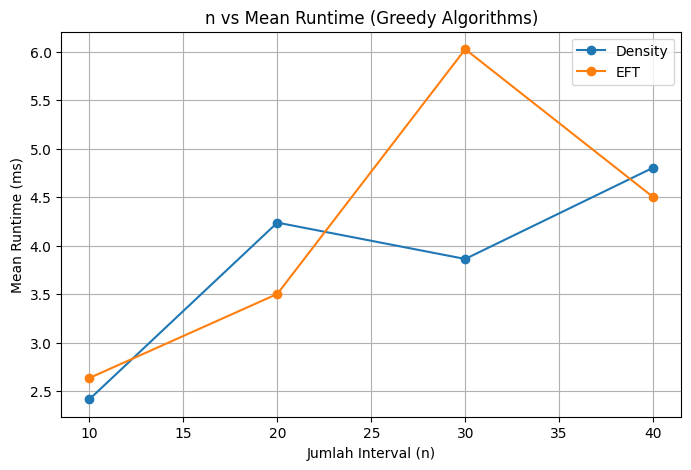

In [87]:
import matplotlib.pyplot as plt

# =========================================================
# LINE CHART: n vs Mean Runtime (Greedy)
# =========================================================

plt.figure(figsize=(8, 5))

for algo in mean_runtime_table['algorithm'].unique():
    subset = mean_runtime_table[
        mean_runtime_table['algorithm'] == algo
    ]

    plt.plot(
        subset['n'],
        subset['mean_runtime_ms'],
        marker='o',
        label=algo
    )

plt.xlabel('Jumlah Interval (n)')
plt.ylabel('Mean Runtime (ms)')
plt.title('n vs Mean Runtime (Greedy Algorithms)')
plt.legend()
plt.grid(True)

plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_34612\3368475889.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


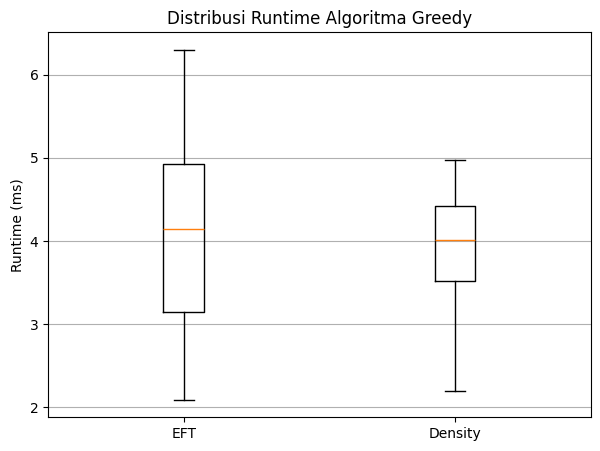

In [88]:
import matplotlib.pyplot as plt

# =========================================================
# BOXPLOT: Runtime per Algoritma (tanpa n)
# =========================================================

plt.figure(figsize=(7, 5))

# Ambil data runtime per algoritma
data_to_plot = [
    results_df[results_df['algorithm'] == 'EFT']['runtime_ms'],
    results_df[results_df['algorithm'] == 'Density']['runtime_ms']
]

plt.boxplot(
    data_to_plot,
    labels=['EFT', 'Density'],
    showfliers=True
)

plt.ylabel('Runtime (ms)')
plt.title('Distribusi Runtime Algoritma Greedy')

plt.grid(True, axis='y')
plt.show()


In [90]:
# =========================================================
# PIVOT: EFT vs Density
# =========================================================

pivot_df = results_df.pivot_table(
    index=['n', 'seed'],
    columns='algorithm',
    values='total_sks'
).reset_index()

print(pivot_df.head())


algorithm   n  seed  Density   EFT
0          10     0     24.0  24.0
1          10     1     28.0  28.0
2          20     0     46.0  46.0
3          20     1     47.0  47.0
4          30     0     64.0  64.0


In [91]:
# =========================================================
# HITUNG GAP (%)
# =========================================================

pivot_df['gap_percent'] = (
    (pivot_df['EFT'] - pivot_df['Density']) / pivot_df['EFT']
) * 100

print(pivot_df[['n', 'seed', 'gap_percent']])


algorithm   n  seed  gap_percent
0          10     0          0.0
1          10     1          0.0
2          20     0          0.0
3          20     1          0.0
4          30     0          0.0
5          30     1          0.0
6          40     0          0.0
7          40     1          0.0


In [92]:
# =========================================================
# TABEL: n vs Mean Gap (%)
# =========================================================

mean_gap_table = (
    pivot_df
    .groupby('n')['gap_percent']
    .mean()
    .reset_index()
    .rename(columns={'gap_percent': 'mean_gap_percent'})
)

print("\n===== TABEL n vs MEAN GAP (%) =====")
print(mean_gap_table)



===== TABEL n vs MEAN GAP (%) =====
    n  mean_gap_percent
0  10               0.0
1  20               0.0
2  30               0.0
3  40               0.0


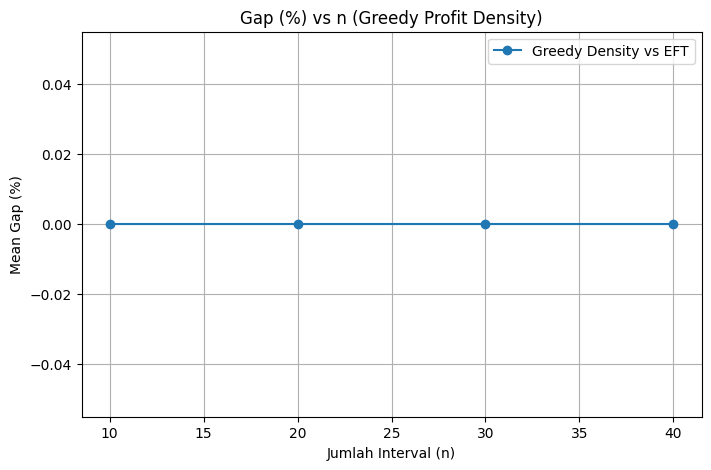

In [93]:
import matplotlib.pyplot as plt

# =========================================================
# LINE CHART: Gap (%) vs n (Greedy)
# =========================================================

plt.figure(figsize=(8, 5))

plt.plot(
    mean_gap_table['n'],
    mean_gap_table['mean_gap_percent'],
    marker='o',
    label='Greedy Density vs EFT'
)

plt.xlabel('Jumlah Interval (n)')
plt.ylabel('Mean Gap (%)')
plt.title('Gap (%) vs n (Greedy Profit Density)')
plt.legend()
plt.grid(True)

plt.show()


In [94]:
# =========================================================
# TABEL: n vs Mean Intervals Processed
# =========================================================

mean_intervals_table = (
    results_df
    .groupby(['n', 'algorithm'])['scheduled_classes']
    .mean()
    .reset_index()
    .rename(columns={'scheduled_classes': 'mean_intervals_processed'})
)

print("\n===== TABEL n vs MEAN INTERVALS PROCESSED =====")
print(mean_intervals_table)



===== TABEL n vs MEAN INTERVALS PROCESSED =====
    n algorithm  mean_intervals_processed
0  10   Density                       9.0
1  10       EFT                       9.0
2  20   Density                      16.5
3  20       EFT                      16.5
4  30   Density                      21.5
5  30       EFT                      21.5
6  40   Density                      27.5
7  40       EFT                      27.5


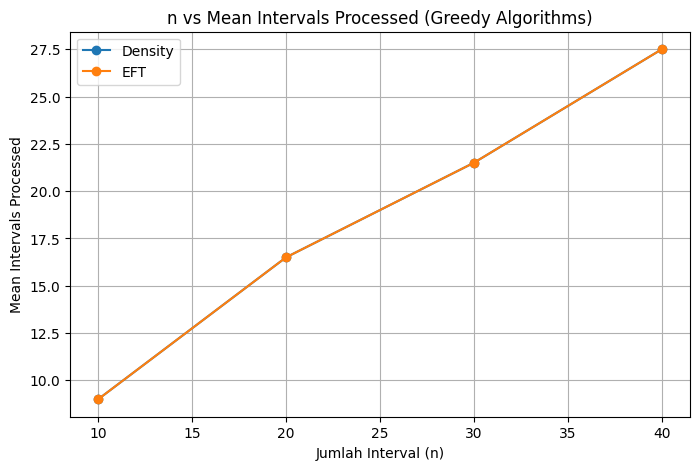

In [95]:
import matplotlib.pyplot as plt

# =========================================================
# LINE CHART: n vs Mean Intervals Processed per Algoritma
# =========================================================

plt.figure(figsize=(8, 5))

for algo in mean_intervals_table['algorithm'].unique():
    subset = mean_intervals_table[
        mean_intervals_table['algorithm'] == algo
    ]

    plt.plot(
        subset['n'],
        subset['mean_intervals_processed'],
        marker='o',
        label=algo
    )

plt.xlabel('Jumlah Interval (n)')
plt.ylabel('Mean Intervals Processed')
plt.title('n vs Mean Intervals Processed (Greedy Algorithms)')
plt.legend()
plt.grid(True)

plt.show()


## (Opsional) Uji Statistik (paired t-test)

## Ekspor tabel LaTeX (opsional)